# Plot voltage thresholds from several tests

## Set up

Here we show how we can compute the thresholds of several configuratations as voltage values. This is particularly useful when we are in a mixed wave of standing wave propagation modes.

In [1]:
from functools import partial

from multipac_testbench import TestCampaign
from multipac_testbench.data import config_path
from multipac_testbench.data.multipactor_tests import (
    test_140MHz_SWR4_11,
    test_140MHz_SWR3_12,
    test_140MHz_SWR2_13,
    test_140MHz_SWR1_14
)
from multipac_testbench.instruments import CurrentProbe, SWR
from multipac_testbench.threshold import AveragedThresholdSet
from multipac_testbench.util.multipactor_detectors import quantity_is_above_threshold

tests = (test_140MHz_SWR4_11, test_140MHz_SWR3_12, test_140MHz_SWR2_13, test_140MHz_SWR1_14)
freqs = (140.0, 140.0, 140.0, 140.0)
swrs = (4.0, 3.0, 2.0, 1.0)

test_campaign =  TestCampaign.from_filepaths(
    tests,
    freqs,
    swrs,
    config_path,
    is_raw=True
)

[INFO    ] [loader.py           ] Applied trigger_policy = 'keep_all' on /home/placais/Documents/simulation/python/multipac_testbench/src/multipac_testbench/data/multipactor_tests/2025.06.20_140MHz-SWR4-11.csv
[ERROR   ] [factory.py          ] column_header = 'NI9205_E1' not present in provided file. Skipping associated instrument.
[INFO    ] [loader.py           ] Applied trigger_policy = 'keep_all' on /home/placais/Documents/simulation/python/multipac_testbench/src/multipac_testbench/data/multipactor_tests/2025.06.20_140MHz-SWR3-12.csv
[ERROR   ] [factory.py          ] column_header = 'NI9205_E1' not present in provided file. Skipping associated instrument.
[INFO    ] [loader.py           ] Applied trigger_policy = 'keep_all' on /home/placais/Documents/simulation/python/multipac_testbench/src/multipac_testbench/data/multipactor_tests/2025.06.20_140MHz-SWR2-13.csv
[ERROR   ] [factory.py          ] column_header = 'NI9205_E1' not present in provided file. Skipping associated instrument

/home/placais/Documents/simulation/python/multipac_testbench/src/multipac_testbench/util/physics.py:28: RuntimeWarning: invalid value encountered in sqrt
  reflection_coefficient = np.abs(np.sqrt(reflected_power / forward_power))
/home/placais/Documents/simulation/python/multipac_testbench/src/multipac_testbench/util/physics.py:28: RuntimeWarning: invalid value encountered in sqrt
  reflection_coefficient = np.abs(np.sqrt(reflected_power / forward_power))


## Calculate multipactor thresholds

Set a multipactor detection criterion:

In [2]:
current_multipactor_criterions = {'threshold': 12., 'minimum_number_of_points': 1}
current_multipac_detector = partial(quantity_is_above_threshold, **current_multipactor_criterions)

Compute all thresholds, for every test at every pick-up:

In [3]:
raw_thresholds = test_campaign.determine_thresholds(current_multipac_detector, CurrentProbe)
for t in raw_thresholds.values():
    t.remove_singularities()             # Avoid multipactor measured on a single point
    t.remove_detected_by("NI9205_MP8l")  # Avoid accounting for same MP twice (E8 is in front of E4)

[WARNING ] [threshold.py        ] User should manually trim exceedent powers in order to avoid flat minima at the end of the test.
[WARNING ] [threshold_set.py    ] Multiple instruments detected at the same position 0.611:
- NI9205_MP4l
- NI9205_MP8l
[WARNING ] [threshold.py        ] User should manually trim exceedent powers in order to avoid flat minima at the end of the test.
[WARNING ] [threshold_set.py    ] Multiple instruments detected at the same position 0.611:
- NI9205_MP4l
- NI9205_MP8l
[WARNING ] [threshold.py        ] User should manually trim exceedent powers in order to avoid flat minima at the end of the test.
[WARNING ] [threshold_set.py    ] Multiple instruments detected at the same position 0.611:
- NI9205_MP4l
- NI9205_MP8l
[WARNING ] [threshold.py        ] User should manually trim exceedent powers in order to avoid flat minima at the end of the test.
[WARNING ] [threshold_set.py    ] Multiple instruments detected at the same position 0.611:
- NI9205_MP4l
- NI9205_M

At every pick-up and for every test, average the thresholds measured after two power cycles:

In [4]:
averaged_thresholds = {
    test: AveragedThresholdSet.from_threshold_set(
        threshold_set,
        predicate=lambda threshold: threshold.sample_index > 80,
    )
    for test, threshold_set in raw_thresholds.items()
}


## Plot multipactor thresholds as voltages

We plot thresholds for every test, at every pick-up (local detection).

[INFO    ] [multipactor_test.py ] What happens when several data wich same xdata?
[INFO    ] [multipactor_test.py ] What happens when several data wich same xdata?
[INFO    ] [multipactor_test.py ] What happens when several data wich same xdata?
[INFO    ] [multipactor_test.py ] What happens when several data wich same xdata?


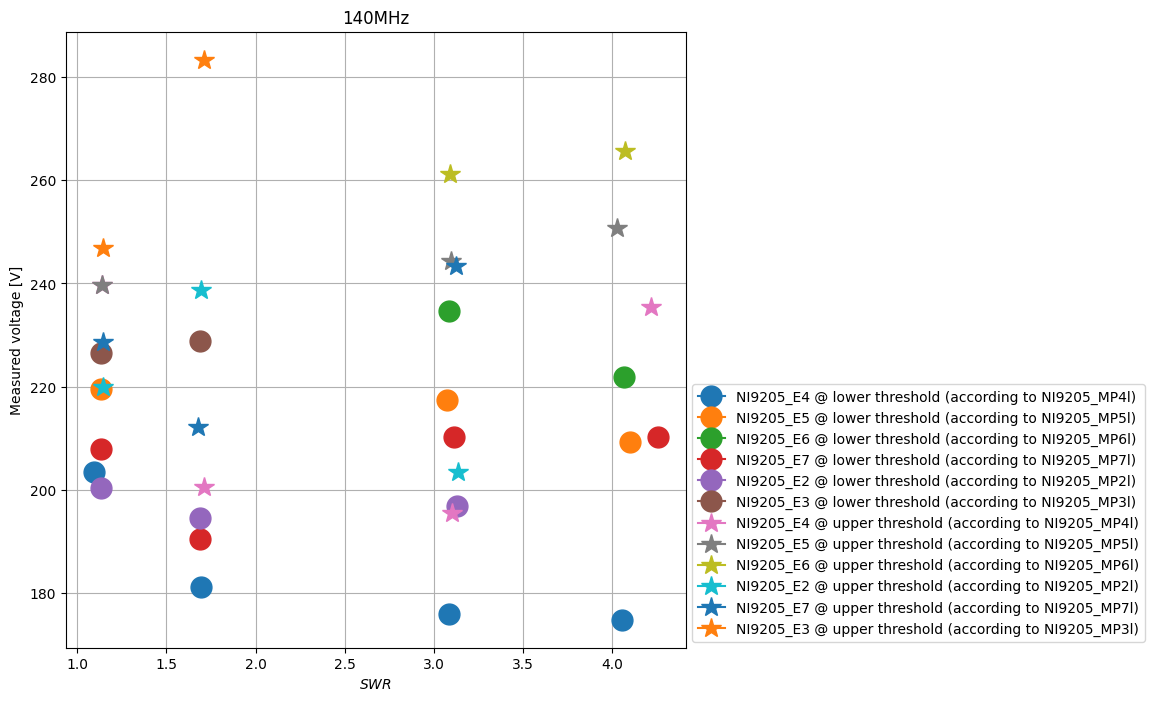

In [5]:
axes_by_freq, dfs_by_freq = test_campaign.check_perez_scaling_law(
    averaged_thresholds,
    xdata=SWR,
    add_upper_thresholds=True,
    figsize=(8, 8),
)
_ = axes_by_freq[140.0].legend(
    loc=(1.01, 0.01),
    ncol=1,
)

In [6]:
df = dfs_by_freq[140.0]
df = df.reindex(sorted(df.columns), axis=1)
df.describe().style.format(precision=1)

,NI9205_E2 @ lower threshold (according to NI9205_MP2l),NI9205_E2 @ upper threshold (according to NI9205_MP2l),NI9205_E3 @ lower threshold (according to NI9205_MP3l),NI9205_E3 @ upper threshold (according to NI9205_MP3l),NI9205_E4 @ lower threshold (according to NI9205_MP4l),NI9205_E4 @ upper threshold (according to NI9205_MP4l),NI9205_E5 @ lower threshold (according to NI9205_MP5l),NI9205_E5 @ upper threshold (according to NI9205_MP5l),NI9205_E6 @ lower threshold (according to NI9205_MP6l),NI9205_E6 @ upper threshold (according to NI9205_MP6l),NI9205_E7 @ lower threshold (according to NI9205_MP7l),NI9205_E7 @ upper threshold (according to NI9205_MP7l)
count,3.0,3.0,2.0,2.0,4.0,4.0,3.0,3.0,2.0,2.0,4.0,3.0
mean,197.2,220.7,227.7,265.2,183.8,217.8,215.4,244.9,228.3,263.5,204.7,228.0
std,2.9,17.7,1.7,25.8,13.4,23.0,5.4,5.5,9.1,3.3,9.5,15.6
min,194.6,203.3,226.5,246.9,174.8,195.4,209.3,239.7,221.8,261.1,190.5,212.2
25%,195.7,211.6,227.1,256.0,175.7,199.2,213.4,242.0,225.1,262.3,203.5,220.4
50%,196.8,219.9,227.7,265.2,178.5,218.0,217.5,244.3,228.3,263.5,209.0,228.6
75%,198.6,229.3,228.3,274.3,186.7,236.6,218.5,247.5,231.5,264.6,210.2,236.0
max,200.4,238.8,228.9,283.4,203.5,239.6,219.4,250.7,234.8,265.8,210.3,243.4
